In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
#rjmc_test_result = np.load('../bayes_implicit_solvent/marginal_likelihood/rjmc_test.npz')

In [4]:
from glob import glob
rjmc_test_result_paths = glob('../bayes_implicit_solvent/marginal_likelihood/rjmc_test_fine_grid/*.npz')
len(rjmc_test_result_paths)

50

In [5]:
rjmc_test_result = np.load(rjmc_test_result_paths[0])

In [6]:
list(rjmc_test_result.keys())

['proposal_sigma',
 'n_types_traj',
 'log_probs',
 'log_accept_prob_traj',
 'proposal_dims',
 'tree_strings',
 'radii',
 'scales']

In [9]:
def get_proposal_sigma(path):
    return np.load(path)['proposal_sigma']

def get_counting_estimate_of_bayes_factor(path):
    n_types_traj = np.load(path)['n_types_traj']
    counting_estimate_of_bayes_factor = np.log(np.sum(n_types_traj==2) / np.sum(n_types_traj==1))
    return counting_estimate_of_bayes_factor

In [58]:
def get_num_accepted_cross_model_proposals(path):
    n_types_traj = np.load(path)['n_types_traj']
    return np.sum(np.diff(n_types_traj) > 0)

In [10]:
proposal_sigmas = np.array([get_proposal_sigma(path) for path in rjmc_test_result_paths])
bayes_factors = np.array([get_counting_estimate_of_bayes_factor(path) for path in rjmc_test_result_paths])

/Users/joshuafass/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Text(0, 0.5, 'RJMC-estimated Bayes factor - AIS-guessed Bayes factor')

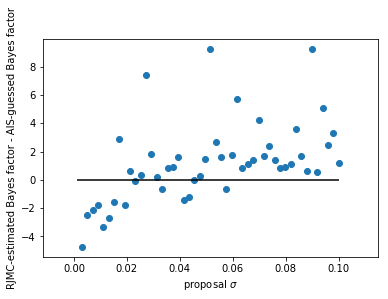

In [16]:
plt.scatter(proposal_sigmas, bayes_factors)
plt.hlines(0, min(proposal_sigmas), max(proposal_sigmas))
plt.xlabel('proposal $\sigma$')
plt.ylabel('RJMC-estimated Bayes factor - AIS-guessed Bayes factor')

In [19]:
proposal_dims = rjmc_test_result['proposal_dims']
len(proposal_dims)

10000

In [21]:
log_accept_probs = rjmc_test_result['log_accept_prob_traj']
len(log_accept_probs)

10000

In [24]:
radii = rjmc_test_result['radii']
len(radii)

10001

In [25]:
current_dims = np.array(list(map(len, radii[:-1])))
current_dims

array([1, 1, 1, ..., 2, 2, 2])

In [27]:
# how many cross-model proposals did we make from model 1 to model 2?
np.sum((current_dims == 1) * (proposal_dims == 2))

2283

In [29]:
# and the reverse?
np.sum((current_dims == 2) * (proposal_dims == 1))

213

In [30]:
w_F = - log_accept_probs[(current_dims == 1) * (proposal_dims == 2)]
w_R = - log_accept_probs[(current_dims == 2) * (proposal_dims == 1)]

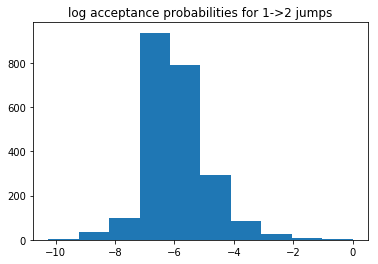

In [36]:
plt.title('log acceptance probabilities for 1->2 jumps')
plt.hist(-w_F);

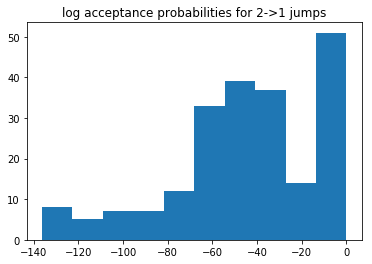

In [38]:
plt.title('log acceptance probabilities for 2->1 jumps')
plt.hist(-w_R);

In [43]:
from pymbar import BAR
BAR(w_F, w_R)

TypeError: bad operand type for unary -: 'list'

In [46]:
def get_estimated_free_energy_difference(path):
    rjmc_test_result = np.load(path)
    proposal_dims = rjmc_test_result['proposal_dims']
    log_accept_probs = rjmc_test_result['log_accept_prob_traj']
    radii = rjmc_test_result['radii']
    current_dims = np.array(list(map(len, radii[:-1])))
    w_F = - log_accept_probs[(current_dims == 1) * (proposal_dims == 2)]
    w_R = - log_accept_probs[(current_dims == 2) * (proposal_dims == 1)]
    
    if min(len(w_F), len(w_R)) < 10:
        if len(w_F) < 10:
            DeltaF, dDeltaF = EXP(w_R)
            return (-DeltaF, dDeltaF)
        else:
            return EXP(w_F)
    else:
        return BAR(w_F, w_R)

In [52]:
def get_forward_average_accept_probs(path):
    rjmc_test_result = np.load(path)
    proposal_dims = rjmc_test_result['proposal_dims']
    log_accept_probs = rjmc_test_result['log_accept_prob_traj']
    radii = rjmc_test_result['radii']
    current_dims = np.array(list(map(len, radii[:-1])))
    return np.mean(np.exp(log_accept_probs[(current_dims == 1) * (proposal_dims == 2)]))

In [80]:
rjmc_test_result['log_probs'].shape

(10001,)

Text(0, 0.5, 'model 1->2 acceptance prob')

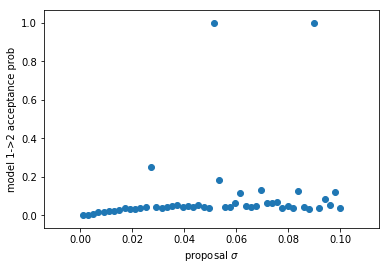

In [57]:
plt.scatter(proposal_sigmas, [get_forward_average_accept_probs(path) for path in rjmc_test_result_paths])
#plt.hlines(0, min(proposal_sigmas), max(proposal_sigmas))
plt.xlabel('proposal $\sigma$')
plt.ylabel('model 1->2 acceptance prob')
#plt.yscale('log')

Text(0, 0.5, '# accepted cross-model proposals')

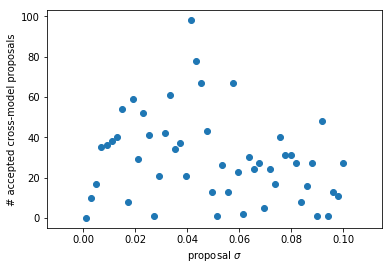

In [60]:
num_accepted_cross_model_proposals = np.array([get_num_accepted_cross_model_proposals(path) for path in rjmc_test_result_paths])
plt.scatter(proposal_sigmas, num_accepted_cross_model_proposals)
#plt.hlines(0, min(proposal_sigmas), max(proposal_sigmas))
plt.xlabel('proposal $\sigma$')
plt.ylabel('# accepted cross-model proposals')
#plt.yscale('log')

Text(0.5, 1.0, 'colored by number of accepted cross-model jumps')

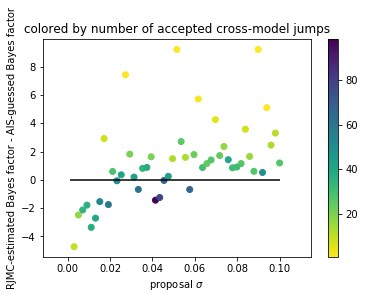

In [71]:
threshold = 10
plt.scatter(proposal_sigmas,
            bayes_factors, c=num_accepted_cross_model_proposals, cmap='viridis_r')
plt.colorbar()
plt.hlines(0, min(proposal_sigmas), max(proposal_sigmas))
plt.xlabel('proposal $\sigma$')
plt.ylabel('RJMC-estimated Bayes factor - AIS-guessed Bayes factor')
plt.title('colored by number of accepted cross-model jumps')

Text(0.5, 1.0, 'colored by whether # accepted\ncross-model jumps > 10')

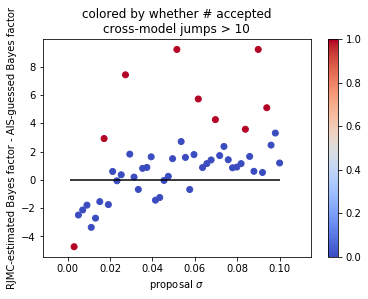

In [77]:
threshold = 10
plt.scatter(proposal_sigmas,
            bayes_factors, c=num_accepted_cross_model_proposals <= threshold, cmap='coolwarm')
plt.colorbar()
plt.hlines(0, min(proposal_sigmas), max(proposal_sigmas))
plt.xlabel('proposal $\sigma$')
plt.ylabel('RJMC-estimated Bayes factor - AIS-guessed Bayes factor')
plt.title('colored by whether # accepted\ncross-model jumps > {}'.format(threshold))

Text(0.5, 1.0, 'only including runs with > 10 accepted cross model jumps')

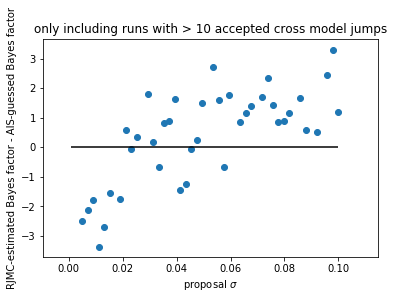

In [78]:
plt.scatter(proposal_sigmas[num_accepted_cross_model_proposals > threshold],
            bayes_factors[num_accepted_cross_model_proposals > threshold])
plt.hlines(0, min(proposal_sigmas), max(proposal_sigmas))
plt.xlabel('proposal $\sigma$')
plt.ylabel('RJMC-estimated Bayes factor - AIS-guessed Bayes factor')
plt.title('only including runs with > 10 accepted cross model jumps')

In [47]:
estimated_free_energy_differences = list(map(get_estimated_free_energy_difference, rjmc_test_result_paths))

Text(0, 0.5, 'RJMC-estimated Bayes factor - AIS-guessed Bayes factor')

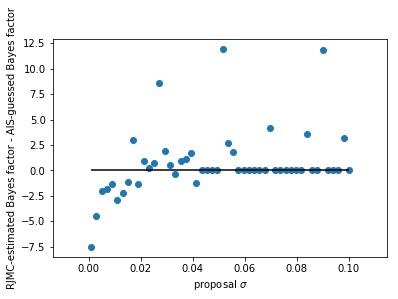

In [49]:
plt.scatter(proposal_sigmas, [-DeltaF for (DeltaF, dDeltaF) in estimated_free_energy_differences])
plt.hlines(0, min(proposal_sigmas), max(proposal_sigmas))
plt.xlabel('proposal $\sigma$')
plt.ylabel('RJMC-estimated Bayes factor - AIS-guessed Bayes factor')

In [41]:
from pymbar import EXP
EXP(w_F), EXP(w_R)

((4.966597615594486, 0.10566865839136712),
 (2.6315789481439897, 0.22962506027559967))

In [7]:
n_types_trajs = rjmc_test_result['n_types_trajs']

In [8]:
log_prob_trajs = rjmc_test_result['log_prob_trajs']

In [9]:
log_accept_prob_trajs = rjmc_test_result['log_accept_prob_trajs']

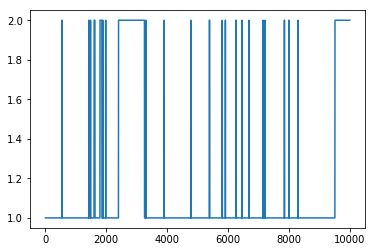

In [17]:
plt.plot(n_types_trajs[1])

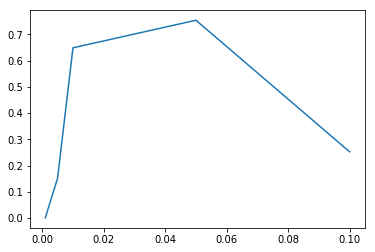

In [35]:
plt.plot(proposal_sigmas, [np.mean(t==2) for t in n_types_trajs])

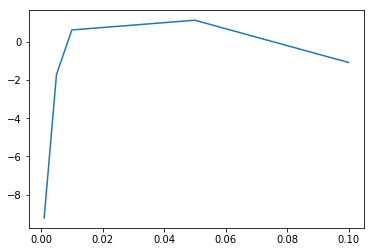

In [37]:

plt.plot(proposal_sigmas, counting_estimate_of_bayes_factor)

In [38]:
counting_estimate_of_bayes_factor

array([-9.21034037, -1.71911803,  0.61392276,  1.12019345, -1.08704686])

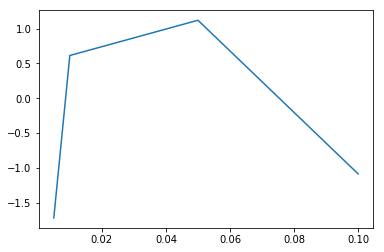

In [40]:
plt.plot(proposal_sigmas[1:], counting_estimate_of_bayes_factor[1:])

array([0.001     , 0.00302041, 0.00504082, 0.00706122, 0.00908163,
       0.01110204, 0.01312245, 0.01514286, 0.01716327, 0.01918367,
       0.02120408, 0.02322449, 0.0252449 , 0.02726531, 0.02928571,
       0.03130612, 0.03332653, 0.03534694, 0.03736735, 0.03938776,
       0.04140816, 0.04342857, 0.04544898, 0.04746939, 0.0494898 ,
       0.0515102 , 0.05353061, 0.05555102, 0.05757143, 0.05959184,
       0.06161224, 0.06363265, 0.06565306, 0.06767347, 0.06969388,
       0.07171429, 0.07373469, 0.0757551 , 0.07777551, 0.07979592,
       0.08181633, 0.08383673, 0.08585714, 0.08787755, 0.08989796,
       0.09191837, 0.09393878, 0.09595918, 0.09797959, 0.1       ])

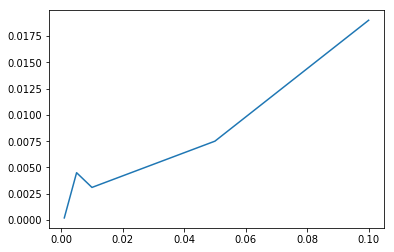

In [23]:
plt.plot(proposal_sigmas, [np.mean(np.diff(t) != 0) for t in n_types_trajs])

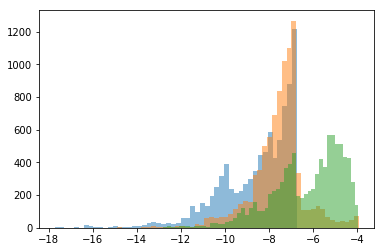

In [43]:
for t in log_prob_trajs[:3]:
    plt.hist(t[1000:], bins=50, alpha=0.5);